# Failure modes

Our algorithm doesn't always work.
It breaks down when a geometry's edge comes very close to a pole, which usually means the GeoJSON geometry is especially strange.
Here's one real-world example from a [Sentinel 3](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-3) [STAC](https://stacspec.org/) Item:

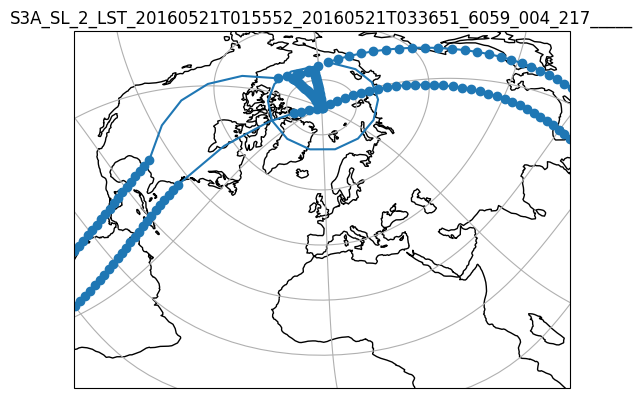

In [1]:
import json
from pathlib import Path
from typing import Any, Dict

from cartopy.crs import PlateCarree, RotatedPole
from matplotlib import pyplot


def read_example(name: str) -> Dict[str, Any]:
    with open(Path("examples") / f"{name}.json") as f:
        return json.load(f)


data = read_example("S3A_SL_2_LST_20160521T015552_20160521T033651_6059_004_217_____")
x = list()
y = list()
for point in data["geometry"]["coordinates"][0]:
    x.append(point[0])
    y.append(point[1])

rotated_pole = RotatedPole(pole_latitude=37.5, pole_longitude=177.5)
plate_carree = PlateCarree()
axes = pyplot.axes(projection=rotated_pole)
axes.set_title("S3A_SL_2_LST_20160521T015552_20160521T033651_6059_004_217_____")
axes.coastlines()
axes.gridlines()
axes.plot(x, y, marker="o", transform=plate_carree)
axes.set_xlim(-90, 90)
pyplot.show()

## What's an algorithm to do?

Our normal algorithm can't handle this strange geometry:

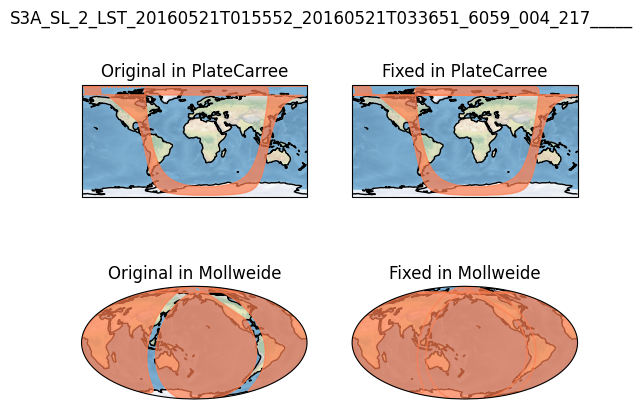

In [2]:
import shapely.geometry
from cartopy.crs import Mollweide, PlateCarree
from shapely.geometry import MultiPolygon, Polygon

import antimeridian


def plot(input: Polygon, output: Polygon | MultiPolygon, name: str) -> None:
    figure = pyplot.figure()
    figure.suptitle(name)

    axes = figure.add_subplot(2, 2, 1, projection=PlateCarree())
    axes.set_title("Original in PlateCarree")
    axes.stock_img()
    axes.coastlines()
    axes.add_geometries(input, crs=PlateCarree(), color="coral", alpha=0.7)

    axes = figure.add_subplot(2, 2, 2, projection=PlateCarree())
    axes.set_title("Fixed in PlateCarree")
    axes.stock_img()
    axes.coastlines()
    axes.add_geometries(output, crs=PlateCarree(), color="coral", alpha=0.7)

    axes = figure.add_subplot(2, 2, 3, projection=Mollweide(central_longitude=180))
    axes.set_title("Original in Mollweide")
    axes.stock_img()
    axes.coastlines()
    axes.add_geometries(input, crs=PlateCarree(), color="coral", alpha=0.7)

    axes = figure.add_subplot(2, 2, 4, projection=Mollweide(central_longitude=180))
    axes.set_title("Fixed in Mollweide")
    axes.stock_img()
    axes.coastlines()
    axes.add_geometries(output, crs=PlateCarree(), color="coral", alpha=0.7)

    pyplot.show()


input = shapely.geometry.shape(data["geometry"])
output = shapely.geometry.shape(antimeridian.fix_geojson(data["geometry"]))
plot(input, output, "S3A_SL_2_LST_20160521T015552_20160521T033651_6059_004_217_____")

## Force the geometry over the north pole

In some cases, we can use our priors to help the algorithm out.
Here, we can force our fixer to extend the geometry over the north pole, which provides a better result:

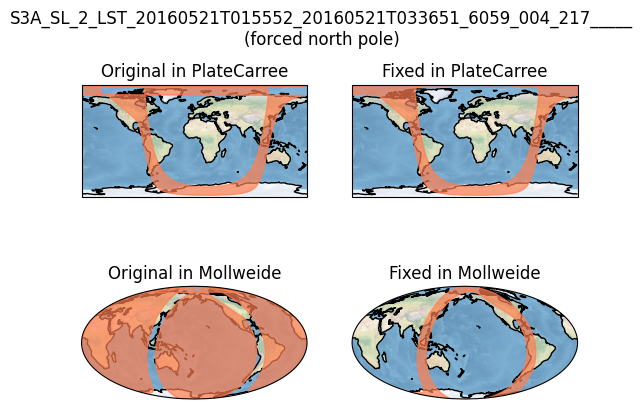

In [ ]:
output = shapely.geometry.shape(
    antimeridian.fix_geojson(data["geometry"], force_north_pole=True)
)
plot(
    input,
    output,
    "S3A_SL_2_LST_20160521T015552_20160521T033651_6059_004_217_____\n"
    "(forced north pole)",
)

## It doesn't always work

Some geometries are so bad that even our north pole hack doesn't produce a valid result:

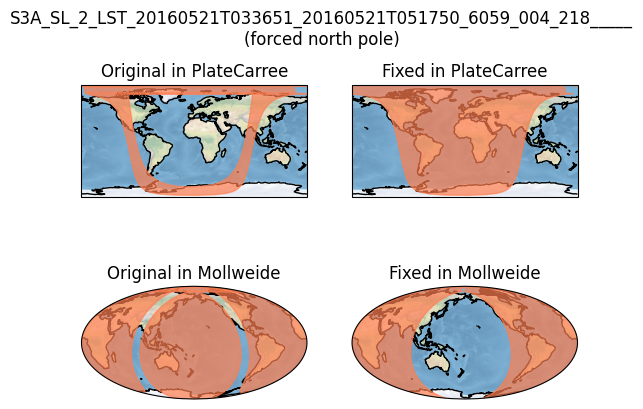

In [ ]:
data = read_example("S3A_SL_2_LST_20160521T033651_20160521T051750_6059_004_218_____")
input = shapely.geometry.shape(data["geometry"])
output = shapely.geometry.shape(
    antimeridian.fix_geojson(data["geometry"], force_north_pole=True)
).buffer(0)
plot(
    input,
    output,
    "S3A_SL_2_LST_20160521T033651_20160521T051750_6059_004_218_____\n"
    "(forced north pole)",
)

In this case, you're better off not using the **antimeridian** package at all, but instead using [shapely's buffer(0) fixer](https://shapely.readthedocs.io/en/stable/manual.html#constructive-methods).
You lose the pole coverage, but at least your geometry is close to what you want:

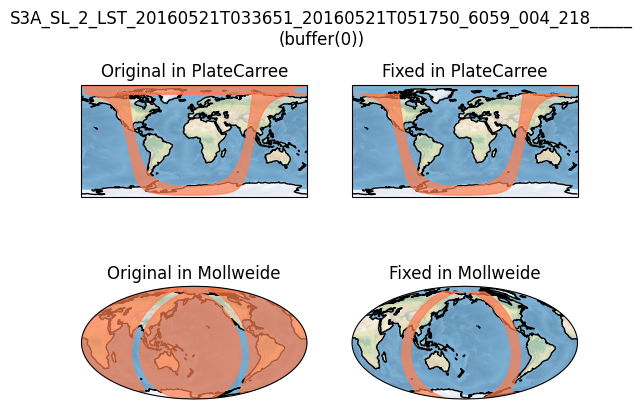

In [5]:
input = shapely.geometry.shape(data["geometry"])
output = input.buffer(0)
plot(
    input,
    output,
    "S3A_SL_2_LST_20160521T033651_20160521T051750_6059_004_218_____\n(buffer(0))",
)

## Conclusions

It's a messy business, dealing with these improperly constructed GeoJSON geometries.
There's probably not going to be one solution that works for every case.